In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [4]:

from samplers.rbf_ecp_marginal import RBFSolverECPMarginal

def get_w(lambda_s, lambda_t, lambdas, x_theta_hist, beta):
    lambda_s = lambda_s.to(torch.float64)
    lambda_t = lambda_t.to(torch.float64)
    lambdas = lambdas.to(torch.float64)
    beta = beta.to(torch.float64)
    x_theta_hist = x_theta_hist.to(torch.float64)
    p = len(lambdas)

    # (p,)
    # x_theta_hist
    # (1,)
    x_theta_zeros = torch.zeros_like(x_theta_hist[:1])
    
    # (p+1,)
    x_theta_aug = torch.cat([x_theta_hist, x_theta_zeros], dim=0)
    # (p, p)
    kernel = RBFSolverECPMarginal.get_kernel_matrix(None,lambdas, beta)
    eye = torch.eye(p+1, device=kernel.device).to(torch.float64)
    kernel_aug = 1 - eye
    kernel_aug[:p, :p] = kernel
    # (p,)
    ws = torch.linalg.solve(kernel_aug, x_theta_aug)
    # ws = ws[:p]  # (p+1,) 중 앞 p개만 슬라이싱
    return ws.float()

def rbf_interpolation(gammas, target_step, ts_reverse, center_hist, ts_ref):
    i = target_step
    beta = 1/(np.exp(gammas[0][i])*abs(ts_reverse[i+1]-ts_reverse[i]))
    center_hist_p = torch.flip(center_hist[i-p+1:i+1], dims=[0])
    ts_reverse_p = torch.flip(ts_reverse[i-p+1:i+1], dims=[0])

    def get_weighted_kernel(ts, w):
        return w[:,None].T*torch.exp(-beta**2 * (ts[:,None] - ts_reverse_p[:,None].T) ** 2)

    ws = get_w(ts_reverse[i], ts_reverse[i+1], ts_reverse_p, center_hist_p, beta)

    wk = get_weighted_kernel(ts_ref,ws[:-1])
    
    return wk, ws[-1]

In [5]:

def plot_graph(center_hist, lambdas, lambdas_ref, b, target_step, gammas ):

    wk,w_const = rbf_interpolation(gammas, target_step, lambdas, center_hist, lambdas_ref[:-1])
    # ── ① 예측값 ──────────────────────────────
    # center_hist  ↔  ts[:-1]  (길이 8)  
    plt.scatter(lambdas[:-1],            # x-축: 예측 시간점
                center_hist,        # y-축: 예측값
                marker='o',
                s=40,
                color="black",
                zorder=3,
                label='x_0 prediction')
    
    wk_sum = torch.zeros_like(wk[:,0])
    
    for idx in range(3):
        plt.plot(lambdas_ref[:-1],            # x-축: GT 시간점
             wk[:,idx],        # y-축: GT 값
             linewidth=1,
             alpha=0.5,
            #  color='b',
            #  label=f'{idx}th Kernel'
             )
        wk_sum += wk[:,idx]
    
    plt.hlines(            # x-축: GT 시간점
             y=w_const,        # y-축: GT 값
             xmin=lambdas_ref[0].item(),
             xmax=lambdas_ref[-1].item(),
             linewidth=1,
             alpha=0.5,
            #  color='b',
             linestyle="--",
            #  label=f'RBF Basis'
             )
    wk_sum += w_const
    
    plt.plot(lambdas_ref[:-1],            # x-축: GT 시간점
             wk_sum,        # y-축: GT 값
             linewidth=3,
             alpha=1.0,
             color='b',
             label=f' RBF Interpolation')
    
    # ── ③ 그래프 설정 ───────────────────────
    plt.xlabel('time')
    plt.ylabel('value')
    plt.title(str(b)+' - RBF Interpolation')
    # plt.title('RBF Interpolation')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

def show_x_thetas(imgs):
    n = imgs.shape[0]
    imgs = imgs/2.0 + 0.5
    grid = make_grid(imgs, nrow=n, padding=0)
    plt.figure(figsize=(8, 8/n))                   # width=8inch, height는 자동 비율
    plt.axis("off")
    plt.imshow(np.clip(grid.permute(1, 2, 0).cpu().numpy(),0,1))  # C,H,W → H,W,C 로 변환 후 NumPy
    plt.tight_layout()
    plt.show()

def get_center_traj(model_hist, bn, cn):
    b, c, w, h = model_hist[0].shape
    x0_traj = []
    for i in range(len(model_hist)):
        if model_hist[i] is None:
            continue
        x0_traj.append(model_hist[i][bn,cn,int(w/2),int(h/2)].item())
    return torch.Tensor(x0_traj)

In [6]:
# 1 : goldfish, 4.0
# 279: arctic fox, 6.0
# 323: monarch butterfly, 8.0
# 386: african elephant, 8.0
# 130: flamingo, 6.0
# 852: tennis ball, 4.0
# 933: cheeseburger, 6.0
# 562: fountain, 6.0
# 417: balloon, 6.0
# 281: tabby cat, 6.0
# 90:lorikeet, 6.0
# 992: agaric 4.0

In [10]:
p = 3
steps = 6
class_int = 386

gammas = np.load(f"/data/guided-diffusion/scale/rbf_ecp_marginal4.0_128/NFE={steps},p={p}.npz")['optimal_log_scales']
loaded_npz = np.load(f'plot_data_step{steps}_class{class_int}.npz')

In [11]:

model_hist = torch.Tensor(loaded_npz['model_hist'])

lambdas = torch.Tensor(loaded_npz['lambdas'])
ts = torch.Tensor(loaded_npz['ts'])

# reverse time axis for plotting...
ts_reverse = torch.Tensor([1-t for t in ts])

ts_ref = torch.arange(0, 1, 1/1000)

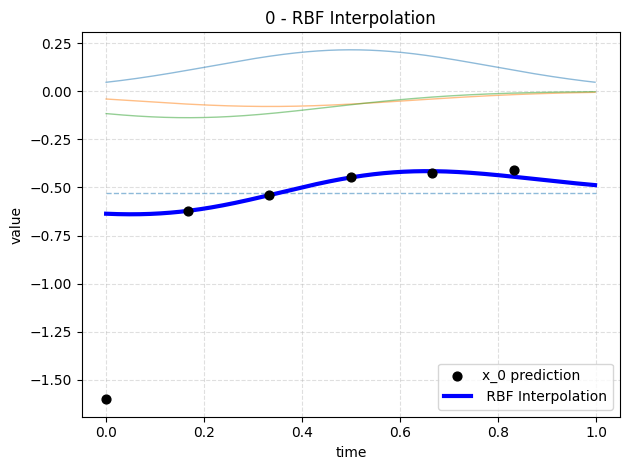

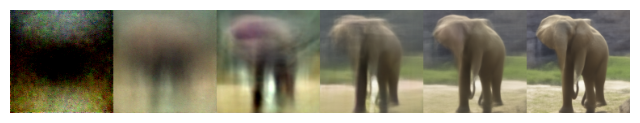

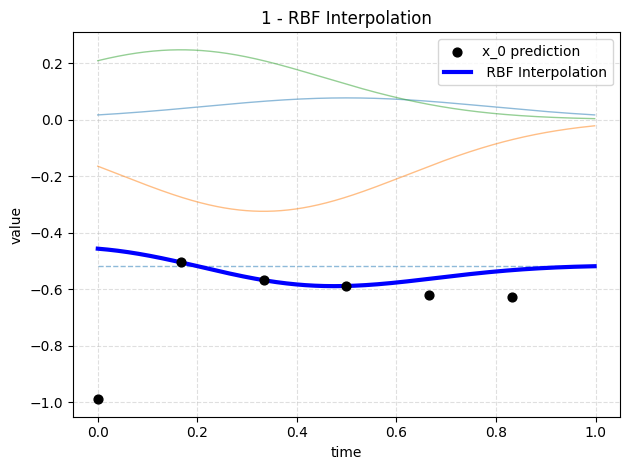

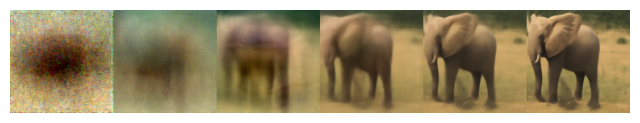

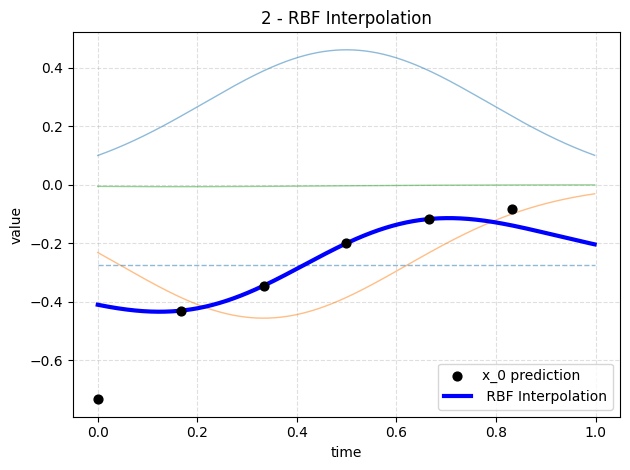

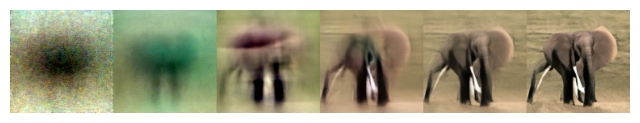

In [12]:
target_step = 3

# for b in range(49):
    # for c in range(3): # channels
for b in range(3):
    for c in [1]:
        center_hist = get_center_traj(model_hist, b, c)
        plot_graph(center_hist, ts_reverse, ts_ref, b, target_step, gammas)
    show_x_thetas(model_hist[:,b])